In [5]:
import os
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
import tensorflow_probability.substrates.jax as tfp

In [6]:
tfd = tfp.distributions
rng = jax.random.PRNGKey(0)

In [7]:
from lcmcmc.utils import get_data_dir_path

# Load data

In [9]:
new_object_df = pd.read_csv(os.path.join(get_data_dir_path(), "bazin_dataset.csv"), index_col=False)

In [10]:
# first select area of expected signal... -60 to +60 days
new_object_df[(new_object_df["time"].values>-30) & (new_object_df["time"].values<30)]

,Unnamed: 0,SNID,time,flux,fluxerr,object_index,band_index,norm_factor
0,0,5081715,-1.4000,1.246278,0.287578,0,1,265.440584
1,1,5081715,0.0000,1.000000,0.249833,0,0,265.440584
2,2,6596653,-1.0000,0.602328,0.143789,1,1,494.681320
3,3,6596653,0.0000,0.357976,0.095791,1,1,494.681320
4,4,6596653,0.0000,1.000000,0.177067,1,0,494.681320
...,...,...,...,...,...,...,...,...
40389,40389,93908538,19.9978,0.556569,0.138986,999,0,409.059418
40390,40390,93908538,20.0207,0.017564,0.148990,999,1,409.059418
40391,40391,93908538,23.0186,0.262706,0.118521,999,1,409.059418
40392,40392,93908538,25.9978,0.052418,0.104422,999,1,409.059418


In [11]:
new_object_df=new_object_df[:1000]

In [12]:
new_object_df  = new_object_df[new_object_df["object_index"].isin(np.arange(0,20))]

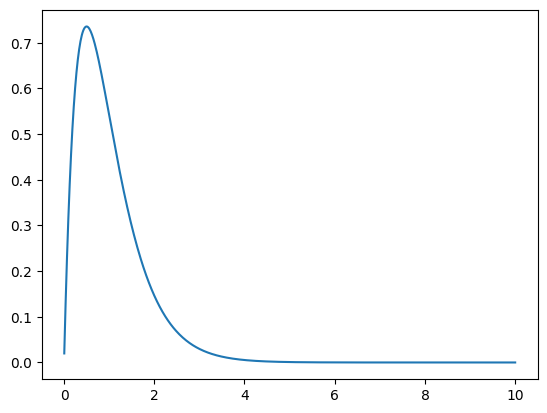

In [13]:
import matplotlib.pyplot as plt
x_ = np.linspace(-20, 10, 2000)
prob = tfd.Gamma(2, 2).prob(x_)
plt.plot(x_, prob)

(array([288., 213., 122., 115.,  85.,  48.,  43.,  23.,  20.,  16.,   9.,
          6.,   3.,   2.,   3.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.37614475e-03, 6.98572695e-01, 1.39476931e+00, 2.09096575e+00,
        2.78716254e+00, 3.48335910e+00, 4.17955542e+00, 4.87575197e+00,
        5.57194853e+00, 6.26814508e+00, 6.96434164e+00, 7.66053820e+00,
        8.35673523e+00, 9.05293179e+00, 9.74912834e+00, 1.04453249e+01,
        1.11415215e+01, 1.18377180e+01, 1.25339146e+01, 1.32301111e+01,
        1.39263077e+01, 1.46225042e+01, 1.53187008e+01, 1.60148964e+01,
        1.67110939e+01, 1.74072895e+01, 1.81034870e+01, 1.87996826e+01,
        1.94958801e+01, 2.01920757e+01, 2.08882732e+01]),
 <BarContainer object of 30 artists>)

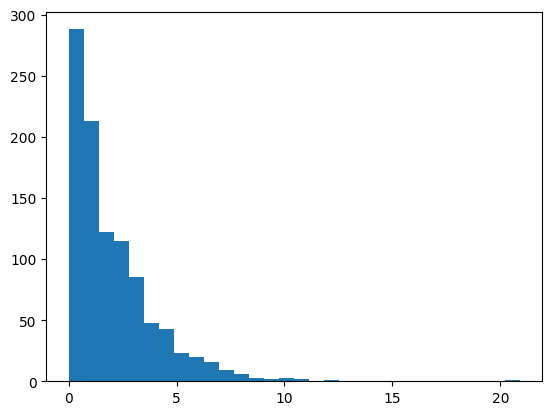

In [14]:
plt.hist(tfd.Gamma(1, .5).sample(1000, seed=rng), bins=30)

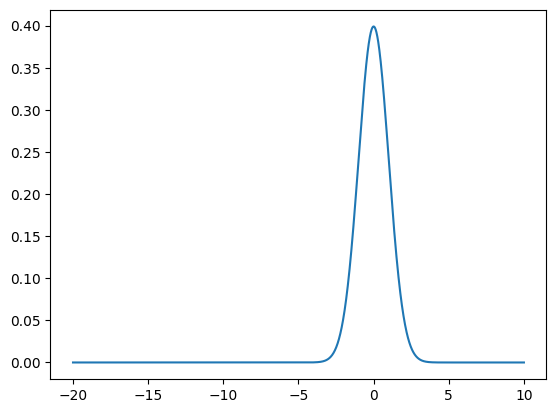

In [15]:
x_ = np.linspace(-20, 10, 2000)
prob = tfd.Normal(0,1).prob(x_)
plt.plot(x_, prob)

# Create joint distribution model

In [16]:
from lcmcmc.model import jd_model
from lcmcmc.parametric_fits import parametric_fn

NOTE that the flux values are normalized. 
To get the actual values, multiply flux and fluxerr columns with norm_factor

In [17]:
index = np.zeros((len(new_object_df), 2), dtype=np.int32)

index[:, 0] = new_object_df["object_index"]
index[:, 1] = new_object_df["band_index"]

x_range = np.asarray(new_object_df["time"])

observed_value = jnp.array(np.asarray(new_object_df["flux"]), dtype=jnp.float32)
observed_sigma = jnp.array(np.asarray(new_object_df["fluxerr"]), dtype=jnp.float32)

jd = jd_model(index, x_range)


In [18]:
jd

<tfp.distributions.JointDistributionCoroutineAutoBatched 'JointDistributionCoroutineAutoBatched' batch_shape=[] event_shape=StructTuple(
  t0_hyper=[20],
  t0=[20, 2],
  t_rise_hyper=[20],
  t_rise=[20, 2],
  t_fall_hyper_prior=[20],
  t_fall_=[20, 2],
  amp=[20, 2],
  sigma=[94],
  obs=[94]
) dtype=StructTuple(
  t0_hyper=float32,
  t0=float32,
  t_rise_hyper=float32,
  t_rise=float32,
  t_fall_hyper_prior=float32,
  t_fall_=float32,
  amp=float32,
  sigma=float32,
  obs=float32
)>

In [19]:
# Run the mcmc

run_mcmc = jax.jit(
    lambda seed: tfp.experimental.mcmc.windowed_adaptive_nuts(
        100, 
        jd, 
        n_chains=4, 
        num_adaptation_steps=100, 
        seed=seed,
        sigma=observed_sigma, 
        obs=observed_value,
    )
)

rng, sample_rng = jax.random.split(rng, 2)
mcmc_samples, sampler_stats = run_mcmc(sample_rng)

In [20]:
#mcmc_samples.t0.shape

In [21]:
#mcmc_samples.t0[10, 0, 13]

In [22]:
import matplotlib.pyplot as plt

In [23]:
# Plot the posterior light curve reconstructions

0


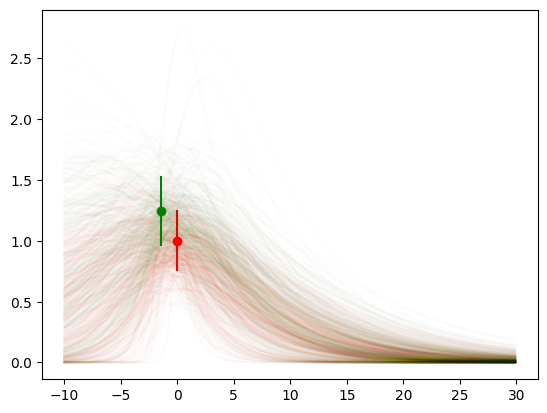

1


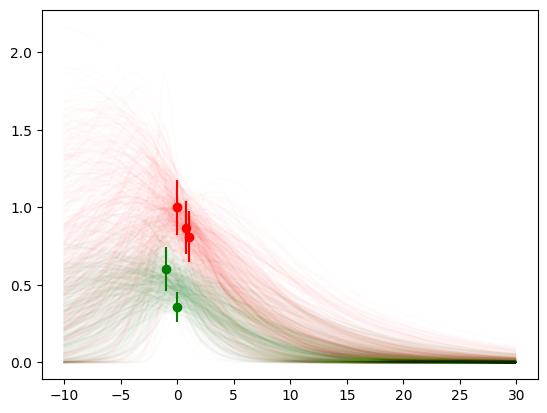

2


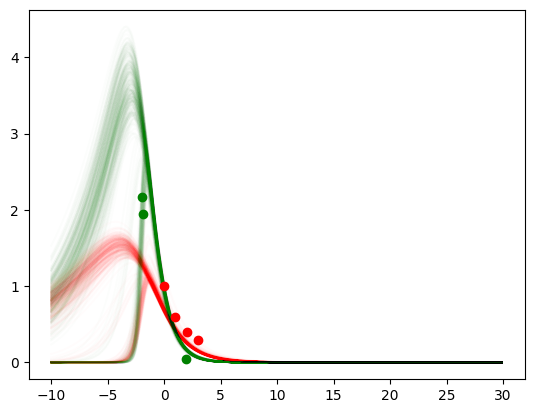

3


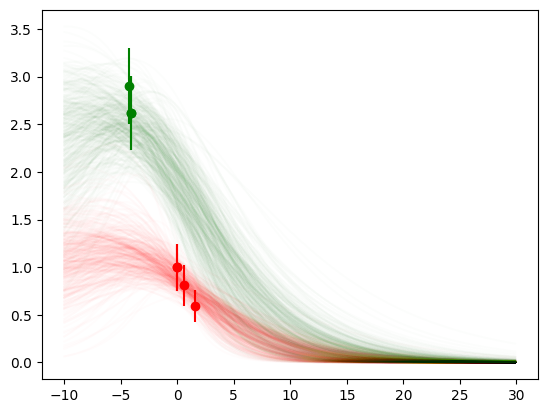

4


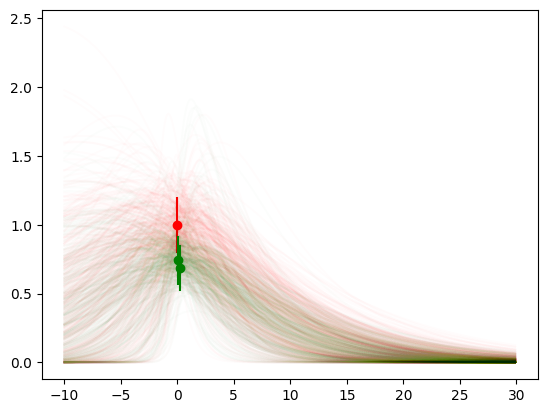

5


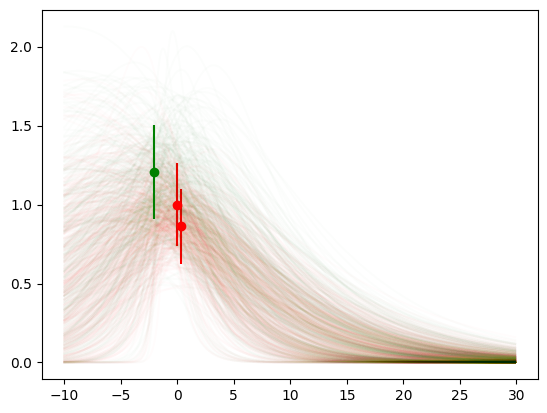

6


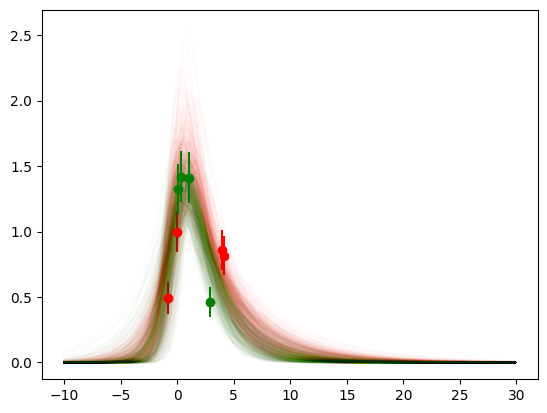

7


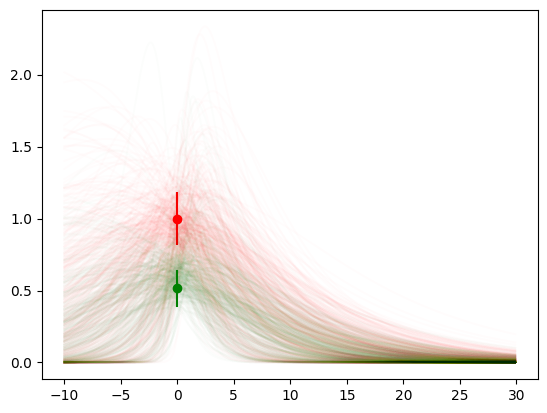

8


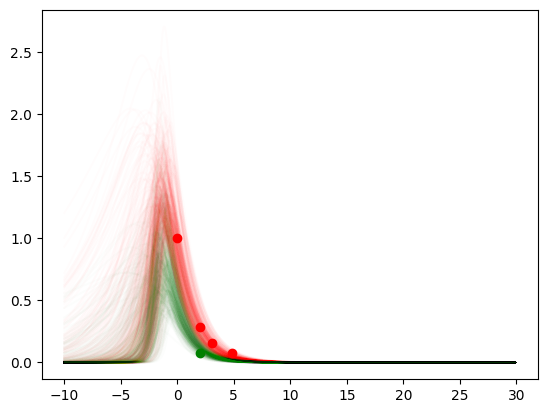

9


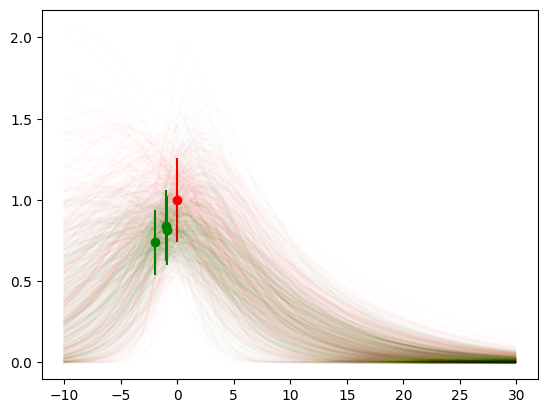

10


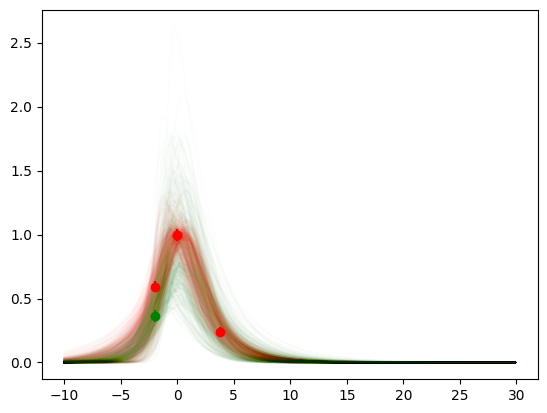

11


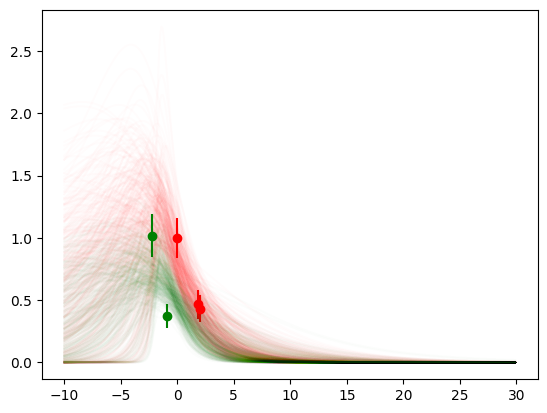

12


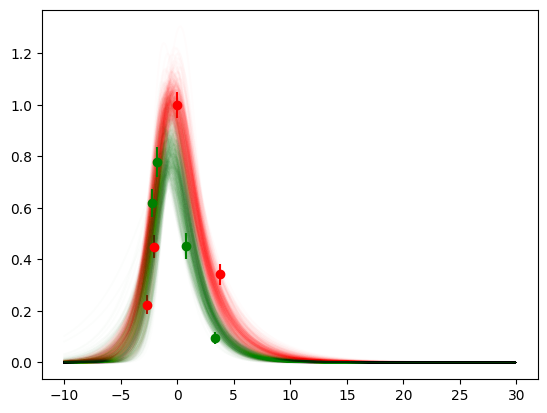

13


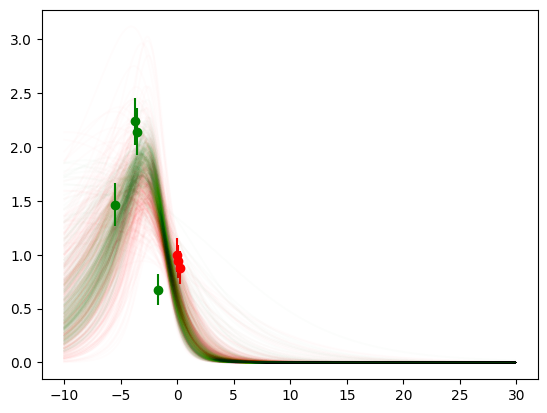

14


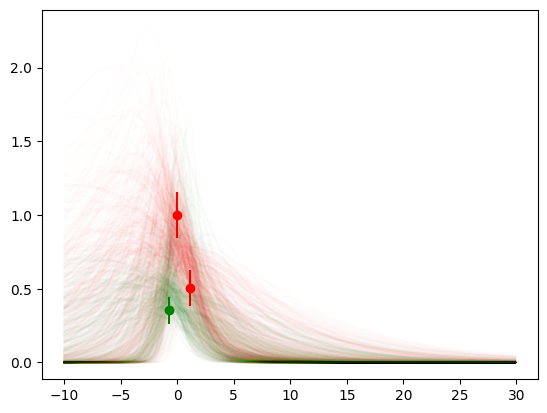

15


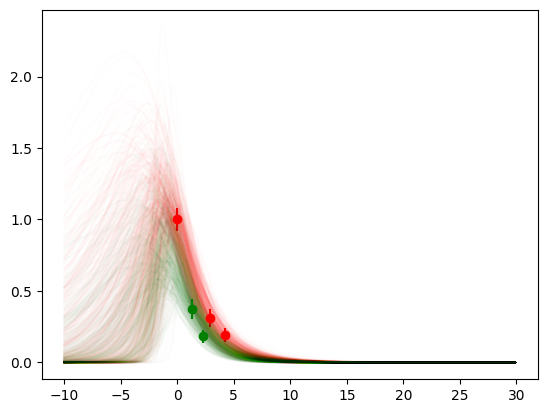

16


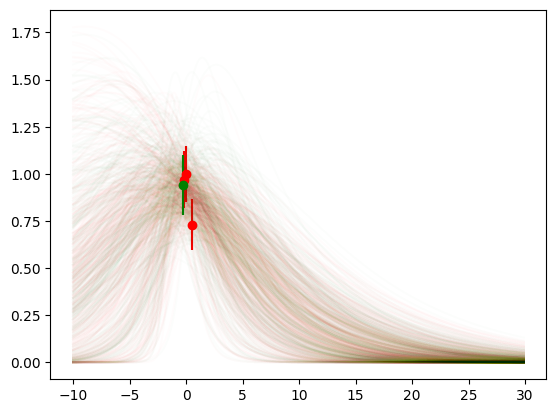

17


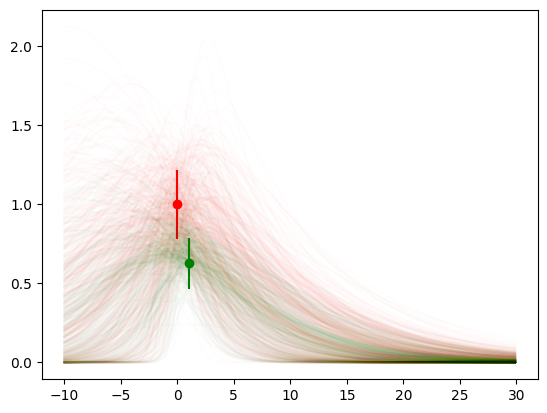

18


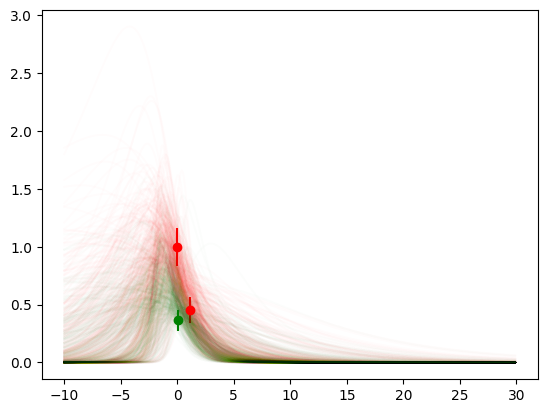

19


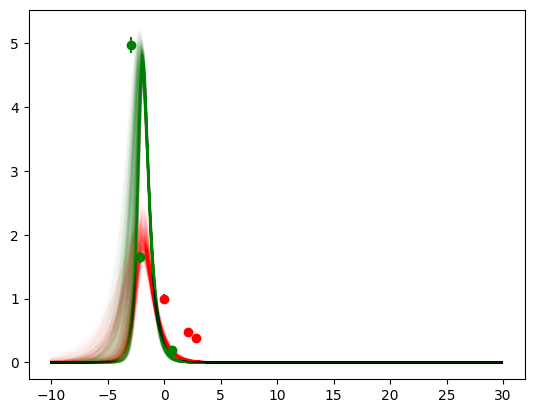

20


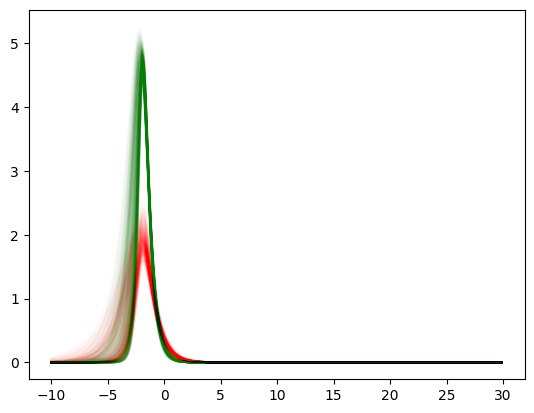

In [24]:
colors = ['r', 'g']
for event_num in range(len(index)):
    print(event_num)
    plt.figure()
    object_df = new_object_df[new_object_df['object_index']==event_num]
    for band in range(2):
        for sample_no in range(100):

            for chain_num in range(4):
                t0 = mcmc_samples.t0_hyper[sample_no, chain_num, event_num]
                t_rise = mcmc_samples.t_rise[sample_no, chain_num, event_num, band]
                t_fall_ = mcmc_samples.t_fall_[sample_no, chain_num, event_num, band]
                t_fall = t_fall_ + t_rise
                amp = mcmc_samples.amp[sample_no, chain_num, event_num, band]

                predictions = parametric_fn(t0, t_rise, t_fall, amp, np.arange(-10,30, .1))
                plt.plot(np.arange(-10,30, .1), predictions, alpha=.01, color=colors[band])


        band_df = object_df[object_df['band_index']==band]
        plt.errorbar(band_df["time"], band_df["flux"], yerr=band_df["fluxerr"], fmt="o", color=colors[band])
    if event_num==20:
        break
    plt.show()
    
#     plt.hist(mcmc_samples.t_rise[sample_no, chain_num, event_num])
#     plt.show()
#     plt.hist(mcmc_samples.t_fall_[sample_no, chain_num, event_num])
#     plt.show()

    
    